### Course - CS-513 Knowledge Discovery and Data Mining
#### Problem Statement - Predict the prices of real estate in New York City using the dataset from Kaggle

In [18]:
# Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Load dataset
df = pd.read_csv('nyc-rolling-sales.csv')

# Dataset columns pre-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [20]:
# Clean dataset

# Drop Unnamed: 0 feature which is just a serial number
# Drop ADDRESS and LOT features as it is not required for analysis.
df.drop(["ADDRESS", "Unnamed: 0", "LOT"], axis=1, inplace=True)

# Check and drop columns where all cells are empty or -
df = df.applymap(lambda x: pd.NA if str(x).strip() in ['-', ''] else x)
df.dropna(axis=1, how='all', inplace=True)

# Dataset columns post-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            83810 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   BUILDING CLASS AT PRESENT       83810 non-null  object
 6   APARTMENT NUMBER                19052 non-null  object
 7   ZIP CODE                        84548 non-null  int64 
 8   RESIDENTIAL UNITS               84548 non-null  int64 
 9   COMMERCIAL UNITS                84548 non-null  int64 
 10  TOTAL UNITS                     84548 non-null  int64 
 11  LAND SQUARE FEET                58296 non-null  object
 12  GROSS SQUARE FEET               56936 non-null

In [21]:
# View dataset statistics

print('(Rows, Columns):', df.shape)
df.head()


(Rows, Columns): (84548, 18)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,BUILDING CLASS AT PRESENT,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,C2,<NA>,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,C7,<NA>,10009,28,3,31,4616,18690,1900,2,C7,<NA>,2016-12-14 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,C7,<NA>,10009,16,1,17,2212,7803,1900,2,C7,<NA>,2016-12-09 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,C4,<NA>,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,C2,<NA>,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [22]:
# Remove rows with total units is not equal to commercial units + residential units
df = df[df["TOTAL UNITS"] == (df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"])]

print(
    "Rows with total units != commercial units + residential units:",
    df[df["TOTAL UNITS"] != df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"]].shape[0],
)

print("\n")

# Check data type of features
print("Data type of features", df.dtypes)

Rows with total units != commercial units + residential units: 0


Data type of features BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
BUILDING CLASS AT PRESENT         object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


In [23]:
# Find categorical columns - columns with less than 10 unique values considered cateogrical for the purpose

categorical_columns = []

for column in df.columns:
    if df[column].dtype == 'object' or df[column].nunique() < 10:
        categorical_columns.append(column)


print('Categorical columns:')
print(categorical_columns, '\n')

Categorical columns:
['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE'] 



In [24]:
# Filter out categorical features from 'categorical_columns' if they are truly useful in categorical sense
categorical_columns = [
    'BOROUGH',
    'NEIGHBORHOOD',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS CATEGORY',
    'BUILDING CLASS AT PRESENT',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING CLASS AT TIME OF SALE',
]

for col in categorical_columns:
    # Convert to categorical data type
    df[col] = df[col].astype('category')
    # Do label encoding
    df[col] = df[col].cat.codes

# Convert other feature data types to numeric wherever suitable
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'])
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

# Convert SALE DATE to datetime and extact year
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
# df['SALE YEAR'] = df['SALE DATE'].dt.year
df["SALE DATE"] = pd.DatetimeIndex(df["SALE DATE"]).year

In [25]:
# Check if all features are appropriately set as per thier data types
print("Data type of features:")
# df.dtypes

Data type of features:


In [26]:
# # Plot histogram for numerical data
# for column in df.columns:
#     # Check if the column is numeric
#     if pd.api.types.is_numeric_dtype(df[column]):
#         # Plot a histogram for numeric data
#         plt.figure(figsize=(8, 4))
#         sns.histplot(df[column], kde=True)
#         plt.title(f"Histogram of {column}")
#         plt.xlabel(column)
#         plt.ylabel("Frequency")
#         plt.show()

    # # Check if the column is categorical
    # elif pd.api.types.is_categorical_dtype(df[column]):
    #     # Plot a countplot for categorical data
    #     plt.figure(figsize=(8, 4))
    #     sns.countplot(x=column, data=df)
    #     plt.title(f'Countplot of {column}')
    #     plt.xlabel(column)
    #     plt.ylabel('Count')
    #     plt.xticks(rotation=45)
    #     plt.show()

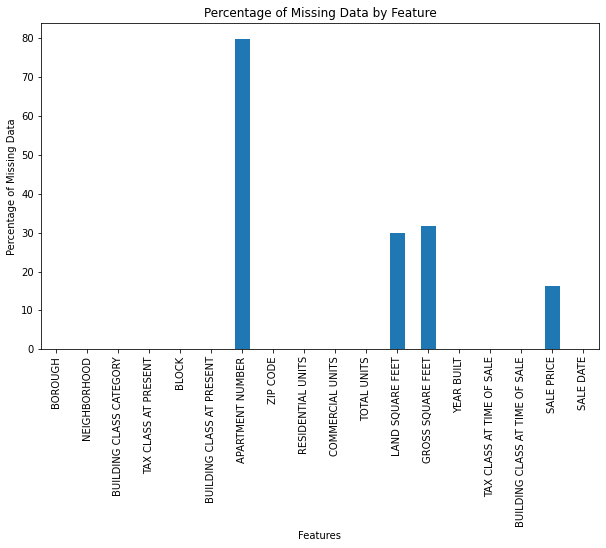

In [27]:
# Missing data - understand percentage of missing data


def show_missing_values(dataframe):
    # Calculate the percentage of missing data in each column
    missing_percentage = dataframe.isnull().mean() * 100

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    missing_percentage.plot(kind="bar")
    plt.ylabel("Percentage of Missing Data")
    plt.xlabel("Features")
    plt.title("Percentage of Missing Data by Feature")

    # Show the plot
    plt.show()

show_missing_values(df)

In [28]:
df.dtypes

# get nunique values of zip code
df['ZIP CODE'].nunique()

186

## Treating Missing Values

In [29]:
# Treating missing values

# Cateogorical values for SALE PRICE
SALE_PRICE_LABELS = ["Low", "Medium", "High", "Very High"]

# Remove rows with missing or 0 values in SALE PRICE which is target variable
df["SALE PRICE"] = df["SALE PRICE"].apply(lambda x: np.NAN if x <= 0 or "" else x)
df.dropna(subset=["SALE PRICE"], inplace=True)

# Check if SALE PRICE has any NA values
print(
    "Number of null or 0 values after cleanup from SALE PRICE:",
    df["SALE PRICE"].isna().sum(),
)


# Delete the APARTMENT NUMBER since 77% of the values are missing and it is not a useful feature
df.drop("APARTMENT NUMBER", axis=1, inplace=True)


# Remove rows with missing values in TAX CLASS AT PRESENT and BUILDING CLASS AT PRESENT
df.dropna(subset=["TAX CLASS AT PRESENT", "BUILDING CLASS AT PRESENT"], inplace=True)

# Do k-means clustering to remove outliers from all numeric features
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
def kmeans_remove_outliers(df, n_clusters=5, random_state=0):
    # Standardize selected features
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(df)
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(standardized_features)
    # Calculate distances of each data point from the cluster centers
    distances = kmeans.transform(standardized_features)
    # Find closest cluster for each data point
    closest_cluster_distances = np.min(distances, axis=1)
    # Determine the threshold value for outliers
    threshold_distance = np.mean(closest_cluster_distances) + 3 * np.std(closest_cluster_distances)
    # Flag the outliers
    outliers = closest_cluster_distances > threshold_distance
    # Remove the outliers
    df = df[~outliers]
    # Change SALE PRICE to categorical variable
    df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)
    return df


df["SALE PRICE"].describe()

# change SALE PRICE to categorical variable
# SALE_PRICE_LABELS = ["Low", "Medium", "High", "Very High"]
# df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)

df.info()

df["SALE PRICE"].value_counts()

Number of null or 0 values after cleanup from SALE PRICE: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 58960 entries, 0 to 84547
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         58960 non-null  int8   
 1   NEIGHBORHOOD                    58960 non-null  int16  
 2   BUILDING CLASS CATEGORY         58960 non-null  int8   
 3   TAX CLASS AT PRESENT            58960 non-null  int8   
 4   BLOCK                           58960 non-null  int64  
 5   BUILDING CLASS AT PRESENT       58960 non-null  int16  
 6   ZIP CODE                        58960 non-null  int64  
 7   RESIDENTIAL UNITS               58960 non-null  int64  
 8   COMMERCIAL UNITS                58960 non-null  int64  
 9   TOTAL UNITS                     58960 non-null  int64  
 10  LAND SQUARE FEET                38270 non-null  float64
 11  GROSS SQUARE FEET               3

10.0        742
450000.0    426
550000.0    414
650000.0    413
600000.0    407
           ... 
313627.0      1
347295.0      1
371500.0      1
458784.0      1
69300.0       1
Name: SALE PRICE, Length: 9742, dtype: int64

In [30]:
# Check if LAND SQUARE FEET and GROSS SQUARE FEET are normally distributed

# plt.figure(figsize=(8, 4))
# sns.histplot(df['LAND SQUARE FEET'], kde=True)
# plt.title('Histogram of LAND SQUARE FEET')
# plt.xlabel('LAND SQUARE FEET')
# plt.ylabel('Frequency')
# plt.show()

# plt.figure(figsize=(8, 4))
# sns.histplot(df['GROSS SQUARE FEET'], kde=True)
# plt.title('Histogram of GROSS SQUARE FEET')
# plt.xlabel('GROSS SQUARE FEET')
# plt.ylabel('Frequency')
# plt.show()

In [31]:
# Create duplicate df for imputation
df_median_impute = df.copy()
df_mean_inpute = df.copy()
df_knn_impute = df.copy()
df_no_impute = df.copy()

# Impute the missing values in LAND SQUARE FEET and GROSS SQUARE FEET using different methods

# Impute using median
df_median_impute['LAND SQUARE FEET'] = df_median_impute['LAND SQUARE FEET'].fillna(df_median_impute['LAND SQUARE FEET'].median())
df_median_impute['GROSS SQUARE FEET'] = df_median_impute['GROSS SQUARE FEET'].fillna(df_median_impute['GROSS SQUARE FEET'].median())
df_median_impute = kmeans_remove_outliers(df_median_impute)

# Impute using mean
df_mean_inpute['LAND SQUARE FEET'] = df_mean_inpute['LAND SQUARE FEET'].fillna(df_mean_inpute['LAND SQUARE FEET'].mean())
df_mean_inpute['GROSS SQUARE FEET'] = df_mean_inpute['GROSS SQUARE FEET'].fillna(df_mean_inpute['GROSS SQUARE FEET'].mean())
df_mean_inpute = kmeans_remove_outliers(df_mean_inpute)

# Impute using KNN
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_knn_impute['LAND SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['LAND SQUARE FEET']])
df_knn_impute['GROSS SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['GROSS SQUARE FEET']])
df_knn_impute = kmeans_remove_outliers(df_knn_impute)

# Delete rows with missing values fir df_no_impute
df_no_impute.dropna(inplace=True)
df_no_impute = kmeans_remove_outliers(df_no_impute)

/var/folders/dv/jnqxrkbx5_x2fyjcbdhqfr3h0000gn/T/ipykernel_91896/3642752013.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)
/var/folders/dv/jnqxrkbx5_x2fyjcbdhqfr3h0000gn/T/ipykernel_91896/3642752013.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)
/var/folders/dv/jnqxrkbx5_x2fyjcbdhqfr3h0000gn/T/ipykernel_91896/3642752013.py:44: SettingWithCopyWarn

In [32]:
# Showing missing values after cleanup
# show_missing_values(df_median_impute)
# show_missing_values(df_mean_inpute)
# show_missing_values(df_knn_impute)

In [33]:
# Model building
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical



def plot_confusion_matrix(cm, title):
    print(title)
    print(cm)
    # ax = plt.subplot()
    # sns.heatmap(cm, annot=True, fmt="g", ax=ax)
    # # annot=True to annotate cells, ftm='g' to disable scientific notation

    # # labels, title and ticks
    # ax.set_xlabel("Predicted labels")
    # ax.set_ylabel("True labels")
    # ax.set_title(title)
    # ax.xaxis.set_ticklabels(SALE_PRICE_LABELS)
    # ax.yaxis.set_ticklabels(SALE_PRICE_LABELS)


def get_predictions(model, X_train, X_test, y_train, y_test):
    # Fit the model to the training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    return model.predict(X_test)

# Return optimal k
def get_optimal_k(dataframe):
    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    k_values = range(1, 21)
    accuracy_map = dict()

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        target_pred = get_predictions(knn, X_train, X_test, y_train, y_test)
        accuracy_map[k] = accuracy_score(y_test, target_pred) * 100

    # Plot the accuracy for different values of k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracy_map.values())
    plt.xticks(k_values)
    plt.xlabel("Value of k")
    plt.ylabel("Testing Accuracy")
    plt.title("Accuracy for different values of k")
    plt.show()

    # Get optimal k
    optimal_k = max(accuracy_map, key=accuracy_map.get)
    return optimal_k

# Return model based on type passed
def get_model(model_type, dataframe):
    if model_type == "gaussian_nb":
        return GaussianNB()
    elif model_type == "decision_tree":
        return DecisionTreeClassifier()
    elif model_type == "cart_5":
        return DecisionTreeClassifier(max_depth=5)
    elif model_type == "random_forest":
        return RandomForestClassifier()
    elif model_type == "svm":
        return SVC()
    elif model_type == "logistic_regression":
        return LogisticRegression()
    elif model_type == "knn":
        # Note for testing - Uncomment below code to get optimal k. It has been commented to avoid running it everytime.
        # optimal_k = get_optimal_k(dataframe)
        # Above function returns optimal k = 8
        optimal_k = 8
        print("The optimal number of neighbors is {}".format(optimal_k))
        return KNeighborsClassifier(n_neighbors=optimal_k)
    # elif model_type == "xg_boost":
    #     return xgb.XGBClassifier()
    # elif model_type == "sequential_dense":
    #     return Sequential()
    else:
        return None

# Write a common function to train and test the different models
def train_and_test_model(model_type, dataframe):
    # Get the model
    model = get_model(model_type, dataframe)

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Get predictions
    target_pred = get_predictions(model, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for " + model_type)

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))

def use_xg_boost_model(dataframe):
    # Initialize the label encoder for the target variable
    label_encoder = LabelEncoder()

    # Copy the dataframe to avoid modifying the original data
    df = dataframe.copy()

    # Fit and transform the 'SALE PRICE' column
    df["SALE PRICE"] = label_encoder.fit_transform(df["SALE PRICE"])

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=["category"]).columns

    # Use pd.get_dummies() to create dummy variables for categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Split the data into features and target
    X = df.drop("SALE PRICE", axis=1)
    y = df["SALE PRICE"]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Create a XGBClassifier model
    xgb_classifier = xgb.XGBClassifier()

    # Fit the model to the training set
    xgb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Generate and print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, "Confusion Matrix for XGBClassifier")

    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, y_pred))


def use_sequential_dense_modal(dataframe):

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    # Convert the target column to categorical (one-hot encoding)
    y_encoded = to_categorical(y.cat.codes)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.3, random_state=42
    )

    # Get the number of input features
    n_features = X_train.shape[1]

    # Create a Sequential model
    model = Sequential()
    model.add(Dense(100, activation="relu", input_shape=(n_features,)))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(4, activation="softmax"))  # Output layer for 4-class classification

    # Compile the model
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Fit the model to the training data
    model.fit(X_train, y_train, epochs=10, validation_split=0.3)

    # Evaluating the Model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Accuracy: {accuracy}")

In [34]:
df_map = {
    "Median Impute": df_median_impute,
    "Mean Impute": df_mean_inpute,
    "KNN Impute": df_knn_impute,
    "No Impute": df_no_impute,
}

for df_key in df_map.keys():
    # Get df_name from key
    print("Dataframe: ", df_key)
    print("\n")

    df_item = df_map[df_key]

    print("KNN")
    train_and_test_model("knn", df_item)
    print("\n")

    print("Gaussian NB")
    train_and_test_model("gaussian_nb", df_item)
    print("\n")

    print("Decision Tree")
    train_and_test_model("decision_tree", df_item)
    print("\n")

    print("CART 5")
    train_and_test_model("cart_5", df_item)
    print("\n")

    print("Random Forest")
    train_and_test_model("random_forest", df_item)
    print("\n")

    print("SVM")
    train_and_test_model("svm", df_item)
    print("\n")


    print("Logistic Regression")
    train_and_test_model("logistic_regression", df_item)
    print("\n")

    print("XG Boost")
    use_xg_boost_model(df_item)
    print("\n")

    print("Sequential Dense Model")
    use_sequential_dense_modal(df_item)
    print("\n\n")

Dataframe:  Median Impute


KNN
The optimal number of neighbors is 8
Confusion Matrix for knn
[[2735  249  688  756]
 [ 407 2931  872  221]
 [ 951  939 2221  225]
 [1037   79  160 3149]]
              precision    recall  f1-score   support

        High       0.53      0.62      0.57      4428
         Low       0.70      0.66      0.68      4431
      Medium       0.56      0.51      0.54      4336
   Very High       0.72      0.71      0.72      4425

    accuracy                           0.63     17620
   macro avg       0.63      0.63      0.63     17620
weighted avg       0.63      0.63      0.63     17620

Accuracy: 0.62633371169126


Gaussian NB
Confusion Matrix for gaussian_nb
[[1228   83 2963  154]
 [ 634   40 3572  185]
 [ 717   44 3483   92]
 [1877  184 1666  698]]
              precision    recall  f1-score   support

        High       0.28      0.28      0.28      4428
         Low       0.11      0.01      0.02      4431
      Medium       0.30      0.80      0.43     

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for logistic_regression
[[1178 1013  601 1636]
 [ 846 2067  502 1016]
 [ 677 1484  925 1250]
 [ 665  421  121 3218]]
              precision    recall  f1-score   support

        High       0.35      0.27      0.30      4428
         Low       0.41      0.47      0.44      4431
      Medium       0.43      0.21      0.29      4336
   Very High       0.45      0.73      0.56      4425

    accuracy                           0.42     17620
   macro avg       0.41      0.42      0.40     17620
weighted avg       0.41      0.42      0.40     17620

Accuracy: 0.41929625425652667


XG Boost
Confusion Matrix for XGBClassifier
[[2692  120  704  912]
 [ 324 2912  935  260]
 [ 840  734 2505  257]
 [ 714   34   88 3589]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      4428
           1       0.77      0.66      0.71      4431
           2       0.59      0.58      0.58      4336
           3       0.72      0.81      0.76  

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for logistic_regression
[[1457  948  625 1345]
 [ 764 1238 1528  833]
 [ 723  897 1683 1009]
 [ 838  538  110 2909]]
              precision    recall  f1-score   support

        High       0.39      0.33      0.36      4375
         Low       0.34      0.28      0.31      4363
      Medium       0.43      0.39      0.41      4312
   Very High       0.48      0.66      0.55      4395

    accuracy                           0.42     17445
   macro avg       0.41      0.42      0.41     17445
weighted avg       0.41      0.42      0.41     17445

Accuracy: 0.4177128116938951


XG Boost
Confusion Matrix for XGBClassifier
[[2658  119  682  916]
 [ 345 2837  943  238]
 [ 795  682 2545  290]
 [ 688   34   63 3610]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      4375
           1       0.77      0.65      0.71      4363
           2       0.60      0.59      0.60      4312
           3       0.71      0.82      0.76   

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for logistic_regression
[[1457  948  625 1345]
 [ 764 1238 1528  833]
 [ 723  897 1683 1009]
 [ 838  538  110 2909]]
              precision    recall  f1-score   support

        High       0.39      0.33      0.36      4375
         Low       0.34      0.28      0.31      4363
      Medium       0.43      0.39      0.41      4312
   Very High       0.48      0.66      0.55      4395

    accuracy                           0.42     17445
   macro avg       0.41      0.42      0.41     17445
weighted avg       0.41      0.42      0.41     17445

Accuracy: 0.4177128116938951


XG Boost
Confusion Matrix for XGBClassifier
[[2658  119  682  916]
 [ 345 2837  943  238]
 [ 795  682 2545  290]
 [ 688   34   63 3610]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      4375
           1       0.77      0.65      0.71      4363
           2       0.60      0.59      0.60      4312
           3       0.71      0.82      0.76   

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for logistic_regression
[[ 649  528  737  948]
 [ 243 1460  616  529]
 [ 285  839 1079  533]
 [ 489  281  298 1758]]
              precision    recall  f1-score   support

        High       0.39      0.23      0.29      2862
         Low       0.47      0.51      0.49      2848
      Medium       0.40      0.39      0.39      2736
   Very High       0.47      0.62      0.53      2826

    accuracy                           0.44     11272
   macro avg       0.43      0.44      0.43     11272
weighted avg       0.43      0.44      0.43     11272

Accuracy: 0.4387863733144074


XG Boost
Confusion Matrix for XGBClassifier
[[1787  129  486  460]
 [ 304 1647  699  198]
 [ 520  576 1522  118]
 [ 424   28   23 2351]]
              precision    recall  f1-score   support

           0       0.59      0.62      0.61      2862
           1       0.69      0.58      0.63      2848
           2       0.56      0.56      0.56      2736
           3       0.75      0.83      0.79   